In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import random
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
from torch_pconv import PConv2d
import glob
import time
import subprocess

In [2]:
original_root = '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files'
landsat_root = '/home/jonstar/scratch.gcurbanheat/autoencoder_train_data'
dataset_root = '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset'

In [3]:
np.random.seed(53)
torch.manual_seed(53)
random.seed(53)

## Data Visualization

In [6]:
dsL = xr.open_dataset(dataset_root+'/DMV/processed_Landsat/Landsat_Sentinel_image_DMV_202201081546.nc')
dsL

FileNotFoundError: [Errno 2] No such file or directory: '/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/DMV/processed_Landsat/Landsat_Sentinel_image_DMV_202201081546.nc'

In [13]:
dsL['Landsat_cloud_mask']

<xarray.DataArray 'Landsat_cloud_mask' (y: 3000, x: 3000)> Size: 72MB
array([['111010101100000', '111010101100000', '111010101100000', ...,
        '101010111000000', '101010111000000', '101010111000000'],
       ['111010101100000', '111010101100000', '111010101100000', ...,
        '101010111000000', '101010111000000', '101010111000000'],
       ['111010101100000', '111011001100000', '111010101100000', ...,
        '101010111000000', '101010111000000', '101010111000000'],
       ...,
       ['101111000010010', '101011100001000', '101011100001000', ...,
        '101111000010010', '101111000010010', '101111001010000'],
       ['101110100010010', '101011100001000', '111011000100010', ...,
        '101110100010010', '101110100010010', '101111000010010'],
       ['101111000010010', '101111000010010', '111011000100010', ...,
        '101111000010010', '101110100010010', '101110100010010']],
      shape=(3000, 3000), dtype=object)
Coordinates:
  * x         (x) float64 24kB 2.92e+05 2.92e+05 ... 3.819e+05 3.82e+05
  * y         (y) float64 24kB 4.282e+06 4.282e+06 ... 4.372e+06 4.372e+06
    datetime  object 8B ...
Attributes:
    bitmask_key:   Bit 0: Fill\n    Bit 1: Dilated Cloud\n    Bit 2: Cirrus (...
    grid_mapping:  spatial_ref

Text(0.5, 0.98, 'Visualization of Landsat Bands, DMV 202201081546')

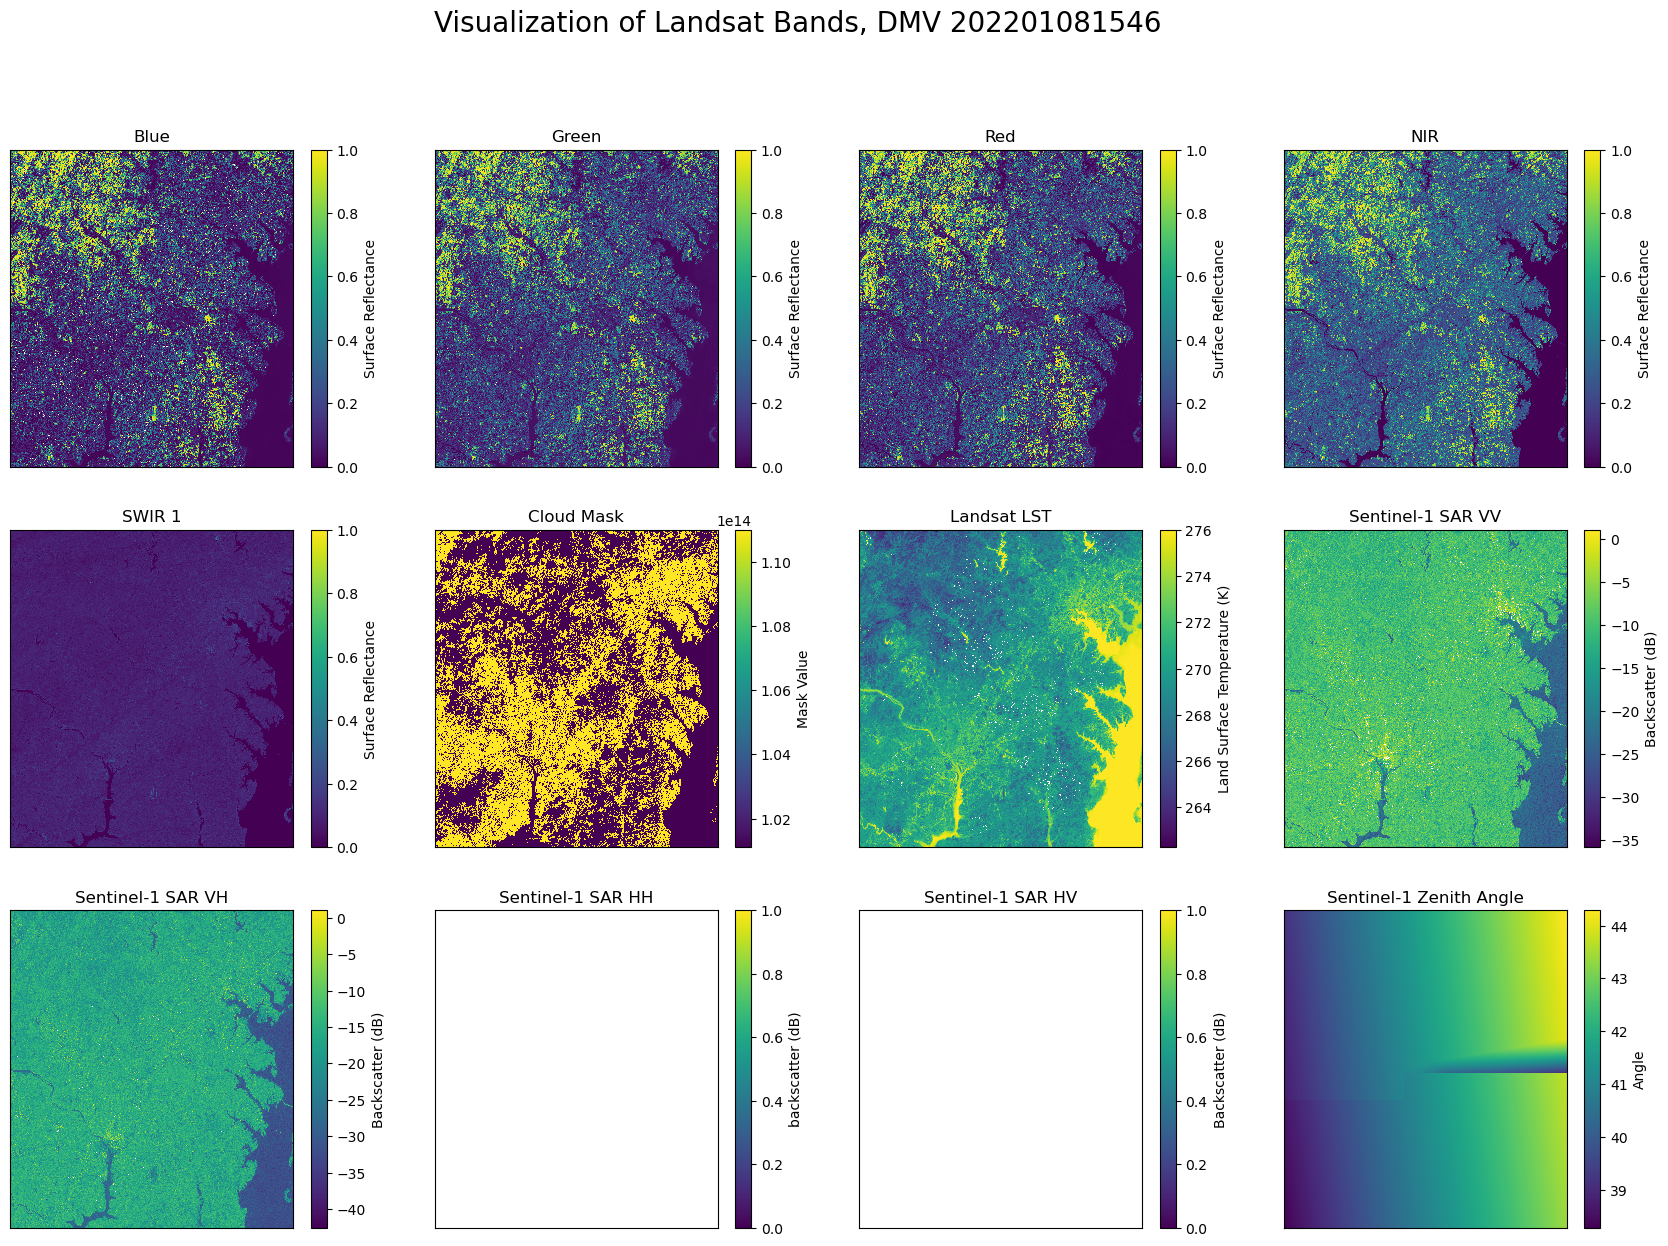

In [14]:
fig, axs = plt.subplots(3, 4)
fig.set_size_inches(21, 14)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

cb = axs[0,0].pcolormesh(dsL['Landsat_blue_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,0], label='Surface Reflectance', orientation='vertical')
axs[0,0].set_title('Blue')
cb = axs[0,1].pcolormesh(dsL['Landsat_green_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,1], label='Surface Reflectance', orientation='vertical')
axs[0,1].set_title('Green')
cb = axs[0,2].pcolormesh(dsL['Landsat_red_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,2], label='Surface Reflectance', orientation='vertical')
axs[0,2].set_title('Red')
cb = axs[0,3].pcolormesh(dsL['Landsat_NIR_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,3], label='Surface Reflectance', orientation='vertical')
axs[0,3].set_title('NIR')
cb = axs[1,0].pcolormesh(dsL['Landsat_SWIR1_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[1,0], label='Surface Reflectance', orientation='vertical')
axs[1,0].set_title('SWIR 1')
cb = axs[1,1].pcolormesh(dsL['Landsat_cloud_mask'].values.astype(np.int64), vmin=101111000010010, vmax=111010101100000)
fig.colorbar(cb, ax=axs[1,1], label='Mask Value', orientation='vertical')
axs[1,1].set_title('Cloud Mask')
cb = axs[1,2].pcolormesh(dsL['Landsat_LST'], vmax=276)
fig.colorbar(cb, ax=axs[1,2], label='Land Surface Temperature (K)', orientation='vertical')
axs[1,2].set_title('Landsat LST')
cb = axs[1,3].pcolormesh(dsL['Sentinel1_VV'], vmax=1)
fig.colorbar(cb, ax=axs[1,3], label='Backscatter (dB)', orientation='vertical')
axs[1,3].set_title('Sentinel-1 SAR VV')
cb = axs[2,0].pcolormesh(dsL['Sentinel1_VH'], vmax=1)
fig.colorbar(cb, ax=axs[2,0], label='Backscatter (dB)', orientation='vertical')
axs[2,0].set_title('Sentinel-1 SAR VH')
cb = axs[2,1].pcolormesh(dsL['Sentinel1_HH'], vmax=1)
fig.colorbar(cb, ax=axs[2,1], label='backscatter (dB)', orientation='vertical')
axs[2,1].set_title('Sentinel-1 SAR HH')
cb = axs[2,2].pcolormesh(dsL['Sentinel1_HV'], vmax=1)
fig.colorbar(cb, ax=axs[2,2], label='Backscatter (dB)', orientation='vertical')
axs[2,2].set_title('Sentinel-1 SAR HV')
cb = axs[2,3].pcolormesh(dsL['Sentinel1_angle'])
fig.colorbar(cb, ax=axs[2,3], label='Angle', orientation='vertical')
axs[2,3].set_title('Sentinel-1 Zenith Angle')

fig.suptitle(f'Visualization of Landsat Bands, DMV 202201081546', fontsize=20)

## Train Test Split

In [15]:
cities = [
    'DMV', 'NYC', 'Phoenix', 'Miami', 'Chicago', 'Denver', 'Seattle', 'San_Francisco', 'Los_Angeles', 'Atlanta', 'Toronto',
    'Mexico_City', 'Las_Vegas', 'Salt_Lake_City', 'Dallas', 'Houston', 'New_Orleans', 'St_Louis', 'Minneapolis', 'Jacksonville',
    'Charlotte', 'Philadelphia', 'San_Diego', 'San_Juan', 'Montreal', 'Guadalajara', 'Monterrey', 'Cancun', 'Billings', 'Guatemala_City',
    'San_Jose', 'Havana', 'Santo_Domingo', 'Tegucigalpa', 'Managua', 'Panama_City', 'Bogota', 'Lima', 'Quito', 'Santiago', 'Buenos_Aires',
    'Sao_Paulo', 'Manaus', 'Punta_Arenas', 'La_Paz', 'Montevideo', 'Brasilia', 'Caracas'
]

In [16]:
nLandsat = []

for city in cities:
    nLandsat.append(len(os.listdir(dataset_root+f'/{city}/processed_Landsat')))

In [34]:
def index_select(nFiles):
    nums = np.arange(nFiles)
    train_indices = np.random.choice(nums, 2, replace=False)
    #test_indices = np.setdiff1d(nums, train_indices)

    return train_indices#, test_indices

In [50]:
def sort_func_Landsat(s, form=int):
    if form == int:
        return int(s.split(f'{city}_')[1].split('.nc')[0])
    else:
        return str(s.split(f'{city}_')[1].split('.nc')[0])

In [35]:
indices = list(map(index_select, nLandsat))
indices

[array([38,  7]),
 array([19, 27]),
 array([ 0, 19]),
 array([21, 18]),
 array([ 7, 32]),
 array([ 4, 13]),
 array([34,  7]),
 array([39,  7]),
 array([17, 21]),
 array([ 0, 20]),
 array([19,  8]),
 array([21, 26]),
 array([44, 10]),
 array([17, 23]),
 array([24, 23]),
 array([21, 17]),
 array([26,  1]),
 array([3, 1]),
 array([18, 14]),
 array([37, 17]),
 array([6, 8]),
 array([34,  8]),
 array([43, 25]),
 array([ 9, 18]),
 array([21, 13]),
 array([24, 34]),
 array([ 6, 12]),
 array([36,  8]),
 array([24, 31]),
 array([ 3, 24]),
 array([27, 26]),
 array([21, 32]),
 array([ 4, 24]),
 array([ 0, 39]),
 array([22, 16]),
 array([ 4, 40]),
 array([24, 37]),
 array([21, 37]),
 array([37, 16]),
 array([39,  5]),
 array([20,  0]),
 array([39,  9]),
 array([27, 10]),
 array([ 8, 16]),
 array([22, 11]),
 array([15,  5]),
 array([14, 36]),
 array([17, 12])]

In [54]:
for i in range(len(cities)):
    city = cities[i]
    train_indices = indices[i]

    Landsat_root = f'{dataset_root}/{city}/processed_Landsat'
    Landsat_tif_list = glob.glob(Landsat_root+'/*.nc')
    Landsat_tif_list = sorted(Landsat_tif_list, key=sort_func_Landsat)

    for index in train_indices:
        subprocess.call(['cp', Landsat_tif_list[index], landsat_root])

## Data preprocessing

In [9]:
def file_mean_std(file):
    ds = xr.open_dataset(file)
    
    means = np.array([
        np.nanmean(ds['Landsat_blue_reflectance']),
        np.nanmean(ds['Landsat_green_reflectance']),
        np.nanmean(ds['Landsat_red_reflectance']),
        np.nanmean(ds['Landsat_SWIR1_reflectance']),
        np.nanmean(ds['Landsat_SWIR2_reflectance']),
        np.nanmean(ds['Landsat_NIR_reflectance']),
        np.nanmean(ds['Landsat_LST']),
        np.nanmean(ds['Sentinel1_VV']),
        np.nanmean(ds['Sentinel1_VH']),
        np.nanmean(ds['Sentinel1_HH']),
        np.nanmean(ds['Sentinel1_HV'])])
    stds = np.array([
        np.nanstd(ds['Landsat_blue_reflectance']),
        np.nanstd(ds['Landsat_green_reflectance']),
        np.nanstd(ds['Landsat_red_reflectance']),
        np.nanstd(ds['Landsat_SWIR1_reflectance']),
        np.nanstd(ds['Landsat_SWIR2_reflectance']),
        np.nanstd(ds['Landsat_NIR_reflectance']),
        np.nanstd(ds['Landsat_LST']),
        np.nanstd(ds['Sentinel1_VV']),
        np.nanstd(ds['Sentinel1_VH']),
        np.nanstd(ds['Sentinel1_HH']),
        np.nanstd(ds['Sentinel1_HV'])])
    
    return means, stds

In [8]:
train_file_list = sorted(glob.glob(original_root+'/*.nc'))
train_file_list

['/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_San_Francisco_202204251845.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_San_Francisco_202309191846.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_San_Jose_202304171553.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_San_Jose_202305031553.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_San_Juan_202205261450.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_San_Juan_202211021450.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_Santiago_202204051433.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Landsat_Sentinel_image_Santiago_202310171433.nc',
 '/home/jonstar/scratch.gcurbanheat/autoencoder_train_orig_files/Lands

In [20]:
import warnings
train_means = []
train_stds = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for file in train_file_list:
        means, stds = file_mean_std(file)
        train_means.append(means)
        train_stds.append(stds)

In [23]:
var_means = np.mean(train_means, axis=0)
var_stds = np.mean(train_stds, axis=0)
np.save('/home/jonstar/scratch.gcurbanheat/autoencoder_means.npy', var_means)
np.save('/home/jonstar/scratch.gcurbanheat/autoencoder_stds.npy', var_stds)

## Split images into smaller images for storage

In [9]:
Landsat_dim = 3000
train_dim = 32
n_files_per_dim = int(np.floor(Landsat_dim/train_dim))
start_i = round((Landsat_dim-n_files_per_dim*train_dim)/2)
Landsat_all_nan = 32*32*7

for file in train_file_list:
    fname = file.split('/')[-1].split('.')[0]
    ds = xr.load_dataset(file)
    arr = ds.to_dataarray()[1:10,:,:].values
    np.save(f'/home/jonstar/scratch.gcurbanheat/autoencoder_train_data/{fname}.npy', arr)
    subprocess.call(['rm', file])

## Get mean and std for each city

In [10]:
var_means = np.load('/home/jonstar/scratch.gcurbanheat/autoencoder_means.npy')
var_stds = np.load('/home/jonstar/scratch.gcurbanheat/autoencoder_stds.npy')

In [11]:
var_means

array([ 1.80223559e-01,  2.00584797e-01,  2.03597359e-01,  2.16304118e-01,
        1.60268845e-01,  3.20509304e-01,  2.84763464e+02, -1.15000229e+01,
       -1.86191124e+01,             nan,             nan])

In [12]:
var_stds

array([ 0.16633751,  0.15593308,  0.1607854 ,  0.11146543,  0.09123794,
        0.16066726, 11.61429311,  4.69555203,  5.27282704,         nan,
               nan])

## Model stuff

In [15]:
#ds = xr.load_dataset(landsat_root+'/Landsat_Sentinel_image_Punta_Arenas_202210181415.nc')
ds = np.load(landsat_root+'/Landsat_Sentinel_image_Punta_Arenas_202210181415.npy', allow_pickle=True)
ds

array([[[0.60619, 0.61653, 0.6194175, ..., 0.09392, 0.09573500000000001,
         0.10065750000000001],
        [0.6155124999999999, 0.6250825, 0.6257699999999999, ...,
         0.08465250000000002, 0.08770499999999998, 0.09669749999999999],
        [0.6162000000000001, 0.6221675, 0.6268425, ...,
         0.08143499999999998, 0.085615, 0.09064749999999999],
        ...,
        [0.1876675, 0.18887749999999998, 0.1864575, ..., 0.985195,
         0.9856075000000002, 0.9840950000000002],
        [0.189125, 0.18832749999999998, 0.18508249999999998, ...,
         0.9805200000000001, 0.9832425, 0.9864600000000001],
        [0.19154500000000002, 0.188575, 0.18516500000000002, ...,
         0.9756800000000001, 0.978485, 0.9823075000000001]],

       [[0.5382100000000001, 0.5550675, 0.5647200000000001, ...,
         0.11212499999999997, 0.11336249999999998, 0.11270249999999998],
        [0.5508875, 0.5648850000000001, 0.5747025000000001, ...,
         0.10739500000000002, 0.10912749999999999, 0

In [16]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [25]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, var_means, var_stds, img_dimension=32, transform=None, standardize=True):
        self.img_list = sorted(glob.glob(img_dir+'/*.npy'))
        self.var_means = var_means
        self.var_stds = var_stds
        self.img_dimension = img_dimension
        self.transform = transform
        self.standardize = standardize

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        clip_y = np.random.randint(low=0, high=3000-self.img_dimension+1)
        clip_x = np.random.randint(low=0, high=3000-self.img_dimension+1)

        #print(self.img_list[idx])

        arr = np.load(self.img_list[idx], allow_pickle=True)[:,clip_y:clip_y+self.img_dimension,clip_x:clip_x+self.img_dimension]
        #arr = xr.open_dataset(self.img_list[idx]).to_dataarray()[1:10,clip_y:clip_y+self.img_dimension,clip_x:clip_x+self.img_dimension].values
        if self.standardize:
            arr = (arr-self.var_means[:9,np.newaxis,np.newaxis])/self.var_stds[:9,np.newaxis,np.newaxis]
          
        image = torch.from_numpy(arr.astype(np.float32))
        if self.transform:
            image = self.transform(image)
            
        return image

In [26]:
train_dataset = TrainDataset(landsat_root, var_means, var_stds)

In [28]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [83]:
def custom_max_pool2d(input_tensor, kernel_size, stride):
    # Get the dimensions of the input tensor
    batch_size, channels, height, width = input_tensor.size()
    
    # Calculate the dimensions of the output tensor
    out_height = (height - kernel_size) // stride + 1
    out_width = (width - kernel_size) // stride + 1
    
    # Initialize the output tensor
    output_tensor = torch.empty((batch_size, channels, out_height, out_width))
    
    # Perform custom max pooling
    for b in range(batch_size):
        for c in range(channels):
            for i in range(out_height):
                for j in range(out_width):
                    # Define the pooling window
                    h_start = i * stride
                    h_end = h_start + kernel_size
                    w_start = j * stride
                    w_end = w_start + kernel_size
                    
                    # Extract the pooling window
                    window = input_tensor[b, c, h_start:h_end, w_start:w_end]
                    
                    # Filter out NaN values
                    window_non_nan = window[~torch.isnan(window)]
                    
                    # Compute the max value in the window, considering non-NaN values
                    if window_non_nan.numel() > 0:
                        output_tensor[b, c, i, j] = window_non_nan.max()
                    else:
                        # If the window contains only NaN values, set the pooled value to NaN
                        output_tensor[b, c, i, j] = float('nan')
    
    return output_tensor

# Example usage
image_data = [[[1.0, float('nan'), float('nan'), 3.0, 4.0, 5.0], [3.0, float('nan'), float('nan'), 5.0, 6.0, 7.0],
               [5.0, float('nan'), float('nan'), 8.0, 9.0, 10.0], [3.0, 4.0, float('nan'), 5.0, 6.0, 7.0],
              [5.0, float('nan'), float('nan'), 8.0, 9.0, 10.0], [3.0, 4.0, float('nan'), 5.0, 6.0, 7.0]]]
image_tensor = torch.tensor(image_data).unsqueeze(0)  # Add batch dimension

pooled_image = custom_max_pool2d(image_tensor, kernel_size=2, stride=2)
print(pooled_image)

tensor([[[[ 3.,  5.,  7.],
          [ 5.,  8., 10.],
          [ 5.,  8., 10.]]]])


In [20]:
class HeatAutoencoder(nn.Module):
    def __init__(self):
        super(HeatAutoencoder, self).__init__()
        #self.mask = (torch.rand(batch_size, 32, 32) > 0.5).to(torch.float32)
        #self.conv1 = PConv2d(in_channels=9, out_channels=4, kernel_size=3, padding=1)
        #self.conv2 = PConv2d(in_channels=4, out_channels=2, kernel_size=3, padding=1)
        #self.conv3 = PConv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1)
        #self.conv4 = PConv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1)
        #self.conv5 = PConv2d(in_channels=4, out_channels=9, kernel_size=3, padding=1)

        self.conv1 = nn.Conv2d(in_channels=9, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=4, out_channels=9, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        #self.mask = torch.where(torch.isnan(x), 0, 1)
        #x, self.mask = self.conv1(x, self.mask)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        #self.mask = torch.where(torch.isnan(x), 0, 1)
        #x, self.mask = self.conv2(x, self.mask)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        #self.mask = torch.where(torch.isnan(x), 0, 1)
        #x, self.mask = self.conv3(x, self.mask)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.upsample(x)

        #self.mask = torch.where(torch.isnan(x), 0, 1)
        #x, self.mask = self.conv4(x, self.mask)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.upsample(x)
        
        #x, self.mask = self.conv5(x, self.mask)
        x = self.conv5(x)
        return x

model = HeatAutoencoder()

In [29]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
num_epochs = 10
logging_interval = 1
skip_epoch_stats = False
save_model = 'test_model.pth'

In [30]:
def custom_loss(outputs, features, mask):
    outputs = outputs[mask == 1]
    features = features[mask == 1]

    return loss_fn(outputs, features)

In [31]:
log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}
start_time = time.time()
for epoch in range(num_epochs):
    running_train_loss = 0
    model.train()
    for batch_idx, features in enumerate(train_dataloader):
        mask = torch.where(torch.isnan(features), 0, 1)
        features = torch.nan_to_num(features, nan=0)
        # FORWARD AND BACK PROP
        logits = model(features)
        loss = custom_loss(logits, features, mask)
        optimizer.zero_grad()
        loss.backward()
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        # LOGGING
        batch_loss = loss.item()
        log_dict['train_loss_per_batch'].append(batch_loss)
        running_train_loss += batch_loss
        if not batch_idx % logging_interval:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  % (epoch+1, num_epochs, batch_idx,
                      len(train_dataloader), batch_loss))
    if not skip_epoch_stats:
        model.eval()
        with torch.set_grad_enabled(False):  # save memory during inference
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, num_epochs, running_train_loss))
            log_dict['train_loss_per_epoch'].append(running_train_loss)
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

torch.save(model.state_dict(), save_model)

Epoch: 001/010 | Batch 0000/0012 | Loss: 1051462826934375607697408.0000
Epoch: 001/010 | Batch 0001/0012 | Loss: 4.8914
Epoch: 001/010 | Batch 0002/0012 | Loss: 1.9091
Epoch: 001/010 | Batch 0003/0012 | Loss: 1051280809451835801731072.0000
Epoch: 001/010 | Batch 0004/0012 | Loss: 3.1147
Epoch: 001/010 | Batch 0005/0012 | Loss: 3.6170


KeyboardInterrupt: 

In [72]:
log_dict

{'train_loss_per_batch': [1.3742554187774658,
  2.455599308013916,
  1.2134584188461304,
  2.229872941970825,
  5.805222034454346,
  1.2767857313156128,
  2.449453830718994,
  1.2491130661501295e+26,
  4.257988929748535,
  1.067126058207994e+24,
  1.051068311607018e+24,
  1.3300511837005615,
  3.1690491747708956e+25],
 'train_loss_per_epoch': [1.2702950098482796e+26]}

In [174]:
arr = torch.stack([train_dataset[10],train_dataset[11]])

/home/jonstar/scratch.gcurbanheat/autoencoder_train_data/Landsat_Sentinel_image_Cancun_202206221609.nc
/home/jonstar/scratch.gcurbanheat/autoencoder_train_data/Landsat_Sentinel_image_Cancun_202311161609.nc


In [175]:
arr

tensor([[[[-6.3540e-01, -7.4981e-01, -7.9742e-01,  ..., -7.2071e-01,
           -5.9258e-01, -5.1670e-01],
          [-6.9872e-01, -7.3443e-01, -7.4567e-01,  ..., -7.3790e-01,
           -7.3261e-01, -7.1608e-01],
          [-8.2420e-01, -7.5873e-01, -7.3212e-01,  ..., -7.5774e-01,
           -6.3739e-01, -7.7709e-01],
          ...,
          [-3.0591e-01, -1.1611e-01, -2.8458e-01,  ...,  1.9768e-01,
            2.4166e-01,  3.9442e-01],
          [-1.6852e-01, -1.8059e-01, -3.6889e-01,  ...,  1.1356e-02,
            2.5521e-01,  5.5247e-01],
          [-2.2109e-01, -3.2112e-01, -3.3484e-01,  ..., -3.5435e-01,
            2.1471e-01,  6.0223e-01]],

         [[-1.2939e+00, -1.4401e+00, -1.4498e+00,  ..., -1.2202e+00,
           -1.0373e+00, -9.8473e-01],
          [-1.3775e+00, -1.4313e+00, -1.4182e+00,  ..., -1.3173e+00,
           -1.3274e+00, -1.2861e+00],
          [-1.5332e+00, -1.4729e+00, -1.4200e+00,  ..., -1.4359e+00,
           -1.2470e+00, -1.3651e+00],
          ...,
     

In [176]:
mask = torch.where(torch.isnan(arr), 0, 1)
features = torch.nan_to_num(arr, nan=0)
# FORWARD AND BACK PROP
logits = model(features)
loss = custom_loss(logits, features, mask)

In [179]:
features

tensor([[[[-6.3540e-01, -7.4981e-01, -7.9742e-01,  ..., -7.2071e-01,
           -5.9258e-01, -5.1670e-01],
          [-6.9872e-01, -7.3443e-01, -7.4567e-01,  ..., -7.3790e-01,
           -7.3261e-01, -7.1608e-01],
          [-8.2420e-01, -7.5873e-01, -7.3212e-01,  ..., -7.5774e-01,
           -6.3739e-01, -7.7709e-01],
          ...,
          [-3.0591e-01, -1.1611e-01, -2.8458e-01,  ...,  1.9768e-01,
            2.4166e-01,  3.9442e-01],
          [-1.6852e-01, -1.8059e-01, -3.6889e-01,  ...,  1.1356e-02,
            2.5521e-01,  5.5247e-01],
          [-2.2109e-01, -3.2112e-01, -3.3484e-01,  ..., -3.5435e-01,
            2.1471e-01,  6.0223e-01]],

         [[-1.2939e+00, -1.4401e+00, -1.4498e+00,  ..., -1.2202e+00,
           -1.0373e+00, -9.8473e-01],
          [-1.3775e+00, -1.4313e+00, -1.4182e+00,  ..., -1.3173e+00,
           -1.3274e+00, -1.2861e+00],
          [-1.5332e+00, -1.4729e+00, -1.4200e+00,  ..., -1.4359e+00,
           -1.2470e+00, -1.3651e+00],
          ...,
     

In [181]:
features[mask == 1]

tensor([-0.6354, -0.7498, -0.7974,  ...,  0.8113,  0.4729,  1.2310])

In [183]:
logits

tensor([[[[-2.8352e-02, -1.6357e+08, -4.4803e+08,  ..., -2.5841e-02,
           -2.5841e-02, -6.4019e-02],
          [-5.6902e+08,  1.0301e+08, -6.2531e+08,  ..., -1.4855e+09,
            2.3994e+09, -3.2930e+07],
          [ 3.5301e+08,  1.4930e+09,  1.0598e+09,  ...,  3.5648e+09,
            6.4478e+09,  1.0209e+09],
          ...,
          [-1.0388e+10,  7.1924e+08,  1.0705e+10,  ...,  4.8797e+10,
            4.4483e+10,  2.7542e+10],
          [-1.1770e+10, -2.9574e+09,  5.4430e+09,  ...,  3.7836e+10,
            3.6111e+10,  2.3128e+10],
          [ 4.3104e+09,  1.6289e+09,  1.1436e+10,  ...,  6.0332e+10,
            5.5609e+10,  3.3672e+10]],

         [[-1.2872e-03, -2.9089e+08, -2.0637e+08,  ..., -6.8784e-03,
           -6.8784e-03, -2.8538e-03],
          [-1.4063e+09, -2.4956e+09, -3.0899e+09,  ..., -1.1092e+10,
           -9.7053e+09, -3.5966e+09],
          [-8.7527e+08, -1.1066e+09, -2.1129e+09,  ..., -1.0726e+10,
           -1.0308e+10, -7.1017e+09],
          ...,
     

## Analysis

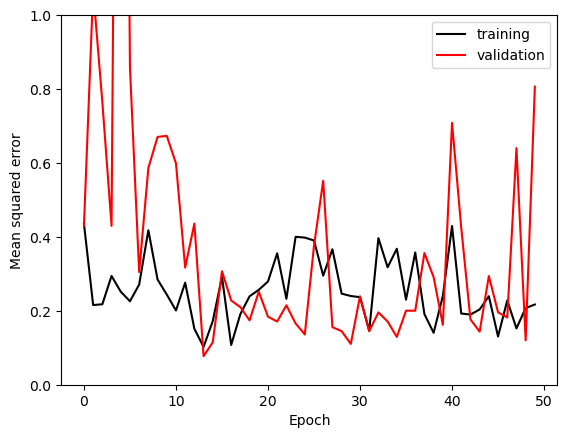

In [19]:
plt.plot(np.array(train_losses), c='k', label='training')
plt.plot(np.array(val_losses), c='r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.ylim(0,1)
plt.legend()
plt.show()

In [20]:
# saving model
#model.save('Unet_crossVal_31epoch_001Adam.keras')

In [24]:
model = keras.models.load_model('Unet_crossVal_31epoch_001Adam.keras')

In [25]:
colors = plt.cm.jet(np.linspace(0, 1, 18))

In [26]:
def assess_skill(x_test, y_test, test_predictions):
    skill_proportions = np.zeros(18) # 18 is the number of test images

    for img in range(18):
        # Takes the spatial average of all reconstructed GOES temperatures
        inp = ((x_test[img,:,:,2]*var_stds[2]+var_means[2])+(x_test[img,:,:,3]*var_stds[3]+var_means[3])+
              (x_test[img,:,:,4]*var_stds[4]+var_means[4])+(x_test[img,:,:,5]*var_stds[5]+var_means[5]))/4
        # Reconstructs target and prediction Landsat LST
        target = y_test[img]*var_stds[8]+var_means[8]
        pred = test_predictions[img,:,:,0]*var_stds[8]+var_means[8]

        skill = np.abs((target-pred)/(target-inp))
        skill_proportions[img] = np.sum(skill<0.5)/64**2

    return skill_proportions

In [30]:
all_skill_proportions = []
nTest = len(os.listdir('/home/jonstar/scratch.gcurbanheat/test_data'))
test_indexes = np.arange(nTest)

for i in np.arange(0, 3000, 256):
    print(i)
    for j in np.arange(0, 3000, 256):  
        x_test, y_test = load_preprocessed_tensor(test_indexes, 'test', 64, [0,1,2,3,4,5,7,8], i, j)
        test_predictions = model(x_test, training=False)
        all_skill_proportions.append(assess_skill(x_test, y_test, test_predictions))

0
256
512
768
1024
1280
1536
1792
2048
2304
2560
2816


In [35]:
np.sum(np.stack(all_skill_proportions) < 0.5)

np.int64(1904)

In [46]:
nTest = len(os.listdir('/home/jonstar/scratch.gcurbanheat/test_data'))
test_indexes = np.arange(nTest)
x_test, y_test = load_preprocessed_tensor(test_indexes, 'test', 64, [0,1,2,3,4,5,7,8])
test_predictions = model(x_test, training=False)
test_loss = model.compute_loss(x_test, test_predictions, y_test, training=False)
print(test_loss.numpy()/nTest)

0.029878804


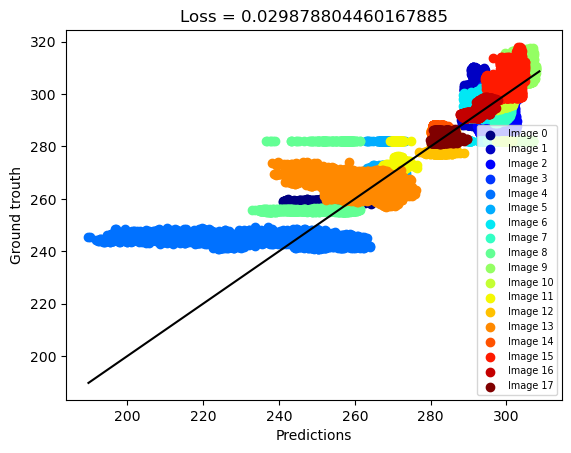

In [47]:
# visualize predictions vs ground truth
lower = np.min(test_predictions*var_stds[8]+var_means[8])
upper = np.max(test_predictions*var_stds[8]+var_means[8])

for dim in range(nTest):
    # Extract points from the tensors
    points1 = test_predictions[dim]*var_stds[8]+var_means[8]
    points2 = y_test[dim]*var_stds[8]+var_means[8]
    #print('points', dim)
    
    # Plot points with corresponding color
    plt.scatter(points1, points2, color=colors[dim], label=f'Image {dim}')
    #print('scatter', dim)
    
plt.plot(np.arange(lower,upper+1), np.arange(lower,upper+1), c='k')
#plt.plot(np.arange(-2, 3), np.arange(-2,3), c='k')
plt.legend(loc='lower right', fontsize='x-small')
plt.xlabel('Predictions')
plt.ylabel('Ground trouth')
plt.title(f'Loss = {test_loss.numpy()/nTest}')
plt.show()

In [39]:
img = 3
inp = ((x_test[img,:,:,2]*var_stds[2]+var_means[2])+(x_test[img,:,:,3]*var_stds[3]+var_means[3])+
      (x_test[img,:,:,4]*var_stds[4]+var_means[4])+(x_test[img,:,:,5]*var_stds[5]+var_means[5]))/4
target = y_test[img]*var_stds[8]+var_means[8]
pred = test_predictions[img,:,:,0]*var_stds[8]+var_means[8]

In [40]:
test_file_list[img]

np.str_('/home/jonstar/scratch.gcurbanheat/temporary_Landsat_data/DMV/Landsat_Sentinel_image_DMV_202207031546.tif')

In [41]:
skill = np.abs((target-pred)/(target-inp))
skill

array([[2.9789221e-01, 2.1509230e-01, 4.0385914e-03, ..., 7.0429422e-02,
        7.0332713e-02, 1.9279315e-01],
       [5.6670602e-02, 5.9758253e-02, 7.9343408e-02, ..., 1.5763021e-01,
        1.9467194e-02, 7.3567726e-02],
       [9.3025245e-02, 6.5306731e-02, 6.2602118e-02, ..., 6.5681495e-04,
        1.3888794e-01, 2.8414458e-01],
       ...,
       [6.4966120e-02, 9.1617726e-02, 4.8089173e-02, ..., 4.8887032e-01,
        3.3834329e-01, 2.0834495e-01],
       [2.9738736e-01, 1.2049666e-01, 1.9903613e-02, ..., 4.1466829e-01,
        3.8170630e-01, 3.5482338e-01],
       [3.1948006e-01, 3.1551439e-02, 9.8433889e-02, ..., 3.9331761e-01,
        6.7461300e-01, 2.7903432e-01]], shape=(64, 64), dtype=float32)

In [42]:
np.sum(skill<0.5)

np.int64(3550)

<Axes: >

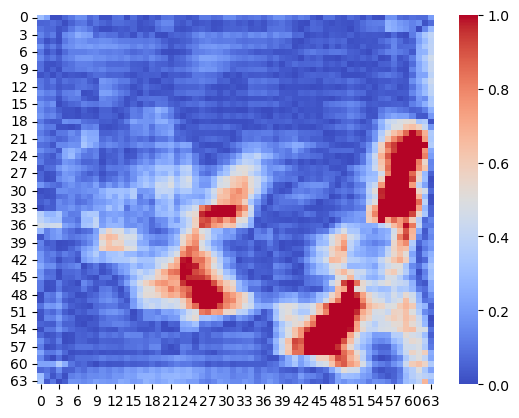

In [43]:
sns.heatmap(skill, vmin=0, vmax=1, cmap='coolwarm')

## XAI

In [81]:
def permutation_feature_importance(model, n_samples=5, n_repeats=3):
    """
    Compute permutation feature importance for a Keras regression model.

    Parameters:
    - model: trained Keras model
    - X: numpy array of shape (n_samples, n_features)
    - y: true target values, shape (n_samples,)
    - n_repeats: number of shuffles per feature

    Returns:
    - Dictionary mapping feature index to importance score
    """
    importances = dict(zip(range(8), np.zeros(8)))
    
    nTest = len(os.listdir('/home/jonstar/scratch.gcurbanheat/test_data'))
    test_indexes = np.arange(nTest)

    for i in range(n_samples):
        x_test, y_test = load_preprocessed_tensor(test_indexes, 'test', 64)
        test_predictions = model(x_test, training=False)
        baseline_test_loss = model.compute_loss(x_test, test_predictions, y_test, training=False).numpy()
    
        for i in range(x_test.shape[-1]):
            scores = []
            for _ in range(n_repeats):
                X_perm = x_test.copy()
                np.random.shuffle(X_perm[:,:,:,i])  # Shuffle only the i-th feature
                test_predictions = model(X_perm, training=False)
                permuted_score = model.compute_loss(X_perm, test_predictions, y_test, training=False).numpy()
                scores.append(permuted_score)
            importances[i] += (np.mean(scores) - baseline_test_loss)/n_samples  # Increase in error

    return importances

In [82]:
imp = permutation_feature_importance(model, n_samples=5)

In [84]:
dict(zip(['single_pol_SAR', 'cross_pol_SAR', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'NDVI', 'NDBI'], imp.values()))

{'single_pol_SAR': np.float64(0.05225470272125676),
 'cross_pol_SAR': np.float64(-0.004571818863041699),
 'CMI_C13': np.float64(0.22818801924586296),
 'CMI_C14': np.float64(0.11137951537966728),
 'CMI_C15': np.float64(-0.9475051611661911),
 'CMI_C16': np.float64(7.276221811771393),
 'NDVI': np.float64(-0.00011973379150731489),
 'NDBI': np.float64(0.0012836695677833632)}

Text(0, 0.5, 'Added Loss')

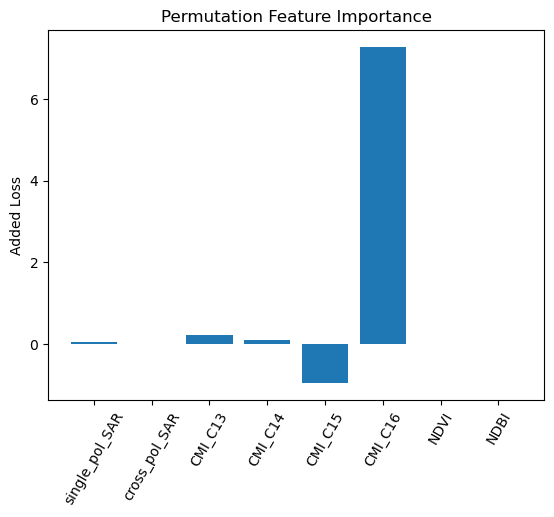

In [88]:
plt.bar(['single_pol_SAR', 'cross_pol_SAR', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'NDVI', 'NDBI'], imp.values())
plt.title('Permutation Feature Importance')
plt.xticks(rotation=60)
plt.ylabel('Added Loss')

In [40]:
x_train, y_train = load_preprocessed_tensor(np.arange(20), 'train', 64, [0,1,2,3,4,5,6,7], 800, 2500)
x_test, y_test = load_preprocessed_tensor(test_indexes, 'test', 64, [0,1,2,3,4,5,6,7], 800, 2500)

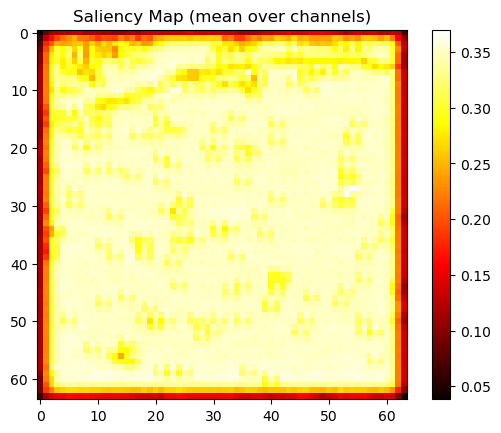

In [47]:
@tf.function
def compute_saliency_map(model, inputs):
    inputs = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)
    grads = tape.gradient(preds, inputs)
    return grads

saliency = compute_saliency_map(model, x_test[4:11])
saliency_np = np.abs(saliency.numpy())
plt.imshow(np.mean(saliency_np[6], axis=-1), cmap='hot')
plt.colorbar()
plt.title("Saliency Map (mean over channels)")
plt.show()